## hana_ml Tutorial - COVID-19
Author: SAP TI HA DB ML China

Date: 2020/5/21

In this tutorial, we will use SAP hana_ml to analyze the public dataset of COVID-19.

## Dataset
We use the public COVID-19 dataset from JHU, https://github.com/CSSEGISandData/COVID-19  (For tutorials only). 

## HANA Connection

First, create a connetion to SAP HANA. To create a such connection, a config file, config/e2edata.ini is used to control the connection parameters.A sample section in the config file is shown below which includes HANA url, port, user and password information.<br>

###################<br>
[hana]<br>
url=host-url<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
###################<br>


In [1]:
from hana_ml.dataframe import ConnectionContext
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = ConnectionContext(url, port, user, pwd)

Connection functions samples:

In [2]:
print(connection_context.connection.isconnected())
print(connection_context.has_table(table='T1'))
print(connection_context.get_current_schema())
print(connection_context.hana_version())

True
False
PAL_TEST
4.50.000.00.1624860913 (master)


## hana_ml DataFrame

### 1. worldwide-aggregated dataset

In [3]:
import pandas as pd
from hana_ml.dataframe import create_dataframe_from_pandas
worldwide = pd.read_csv('../datasets/worldwide-aggregated.csv')
worldwide_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=worldwide, table_name='WORLD', force=True, replace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


In [4]:
worldwide_df

Coverts to Pandas dataframe with collect():

In [5]:
worldwide_df.head(3).collect()

,Date,Confirmed,Recovered,Deaths,Increase rate
0,1/22/2020,555,28,17,0.000000
1,1/23/2020,654,30,18,17.837838
2,1/24/2020,941,36,26,43.883792


In [6]:
worldwide_df.dtypes()

[('Date', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('Confirmed', 'INT', 10, 10, 10, 0),
 ('Recovered', 'INT', 10, 10, 10, 0),
 ('Deaths', 'INT', 10, 10, 10, 0),
 ('Increase rate', 'DOUBLE', 15, 15, 15, 0)]

In [7]:
worldwide_df.columns

['Date', 'Confirmed', 'Recovered', 'Deaths', 'Increase rate']

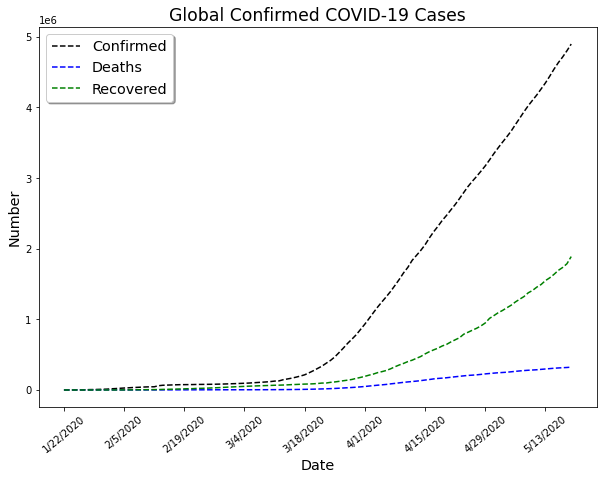

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Global Confirmed COVID-19 Cases', fontsize='xx-large')
ax.plot(worldwide['Date'], worldwide['Confirmed'], 'k--', label='Confirmed')
ax.plot(worldwide['Date'], worldwide['Deaths'], 'b--', label='Deaths')
ax.plot(worldwide['Date'], worldwide['Recovered'], 'g--', label='Recovered')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = worldwide['Date']
xticks=list(range(0,len(Date),14)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### 2. time_series_covid19_confirmed_US dataset

In [9]:
import numpy as np
# Load data, drop unneeded lat/long columns and group by country/region
def loadAndGroup(fileName, groupBy="Province_State", dropColumns=["UID","iso2","iso3","code3","FIPS","Admin2","Country_Region","Lat","Long_","Combined_Key"], extraDrop=[]):   #,"Population"
    df=pd.read_csv(fileName)
    for dc in dropColumns+extraDrop:
        df.drop(dc, axis=1, inplace=True)
    df=df.groupby(groupBy).sum()
    for dc in range(30):
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

def diff(ys):
    res=[0]
    cur=ys[0]
    for y in ys[1:]:
        res.append(y-cur)
        cur=y
    return res

confd         =loadAndGroup('../datasets/time_series_covid19_confirmed_US.csv')
confd         =confd.append(confd.sum(axis=0).rename('US'))
confdDelta    =confd.diff(axis=1).replace(np.nan, 0)

# Preprocess the Data to transpose and add a 'timestamp' column as the first column.
def preprocessData(df):
    df_new = pd.DataFrame(df).T
    id= df_new.index
    col_name=df_new.columns.tolist()
    col_name.insert(0, 'Timestamp')  
    df_new=df_new.reindex(columns=col_name)
    df_new['Timestamp']=id
    return(df_new)

confd_df=preprocessData(confd)
confdDelta_df=preprocessData(confdDelta)

confd_df_hana = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=confd_df, table_name='US_CONFIRMED', force=True, replace=True)
confdDelta_df_hana = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=confdDelta_df, table_name='US_CONFIRMED_DELTA', force=True, replace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


In [10]:
confd_us = connection_context.table('US_CONFIRMED')
confd_us_delta = connection_context.table('US_CONFIRMED_DELTA')
print(confd_us)
print(confd_us_delta)

In [11]:
confd_us.head(3).collect()

,Timestamp,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,US
0,2020-02-21,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15
1,2020-02-22,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15
2,2020-02-23,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15


In [12]:
confd_us_delta.collect().head(3)

,Timestamp,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,US
0,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(confd_us.count())
print(confd_us_delta.count())

89
89


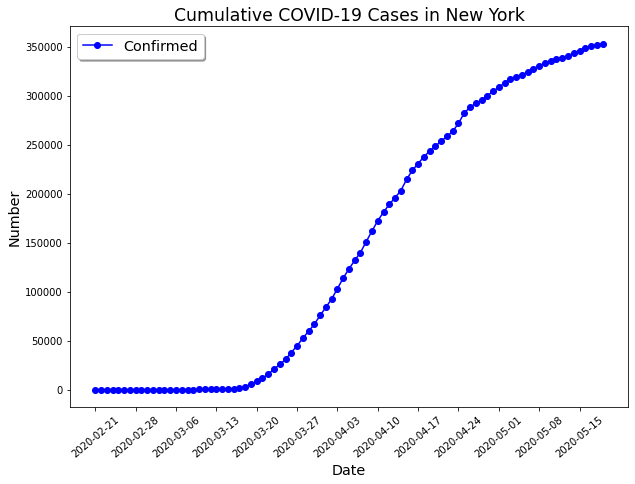

In [14]:
ny_confirmed = confd_us.select('New York').collect()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Cumulative COVID-19 Cases in New York', fontsize='xx-large')
ax.plot(confd_us.collect()['Timestamp'], ny_confirmed, 'b-o', label="Confirmed")
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

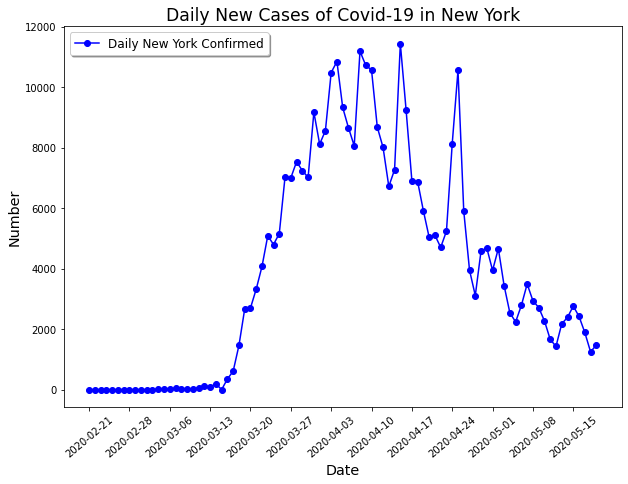

In [15]:
ny_confirmed_delta = confd_us_delta.select('New York').collect()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Daily New Cases of Covid-19 in New York', fontsize='xx-large')
ax.plot(confd_us_delta.collect()['Timestamp'], ny_confirmed_delta, 'b-o', label="Daily New York Confirmed")
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
Date = confd_us_delta.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

## Forecast 

### Time Series Forecast Algorithms - Auto ARIMA, Additive Model Forecast

### Auto ARIMA

In [16]:
ny_confd_delta = confd_us_delta.select('New York').add_id('ID').cast('New York', 'INT')
print(ny_confd_delta.head(5).collect())

   ID  New York
0   1         0
1   2         0
2   3         0
3   4         0
4   5         0


In [17]:
from hana_ml.algorithms.pal.tsa.auto_arima import AutoARIMA

autoarima = AutoARIMA()
autoarima.fit(ny_confd_delta, key="ID")

print(autoarima.model_.collect().head(5))
print(autoarima.fitted_.collect().head(10))

  KEY                      VALUE
0   p                          3
1  AR  1.61782;-1.04105;0.333345
2   d                          1
3   q                          2
4  MA          -1.69531;0.804166
   ID  FITTED  RESIDUALS
0   1     NaN        NaN
1   2     0.0        0.0
2   3     0.0        0.0
3   4     0.0        0.0
4   5     0.0        0.0
5   6     0.0        0.0
6   7     0.0        0.0
7   8     0.0        0.0
8   9     0.0        0.0
9  10     0.0        0.0


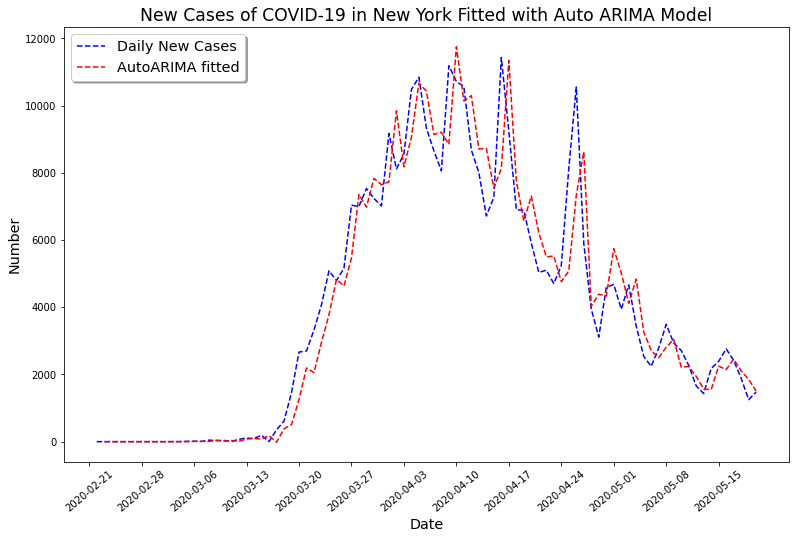

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Fitted with Auto ARIMA Model', fontsize='xx-large')
ax.plot(ny_confd_delta.collect()['ID'], ny_confd_delta.collect()['New York'], 'b--', label = 'Daily New Cases')
ax.plot(autoarima.fitted_.collect()['ID'], autoarima.fitted_.collect()['FITTED'],'r--', label='AutoARIMA fitted')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us_delta.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### Model Storage

In [19]:
from hana_ml.model_storage import ModelStorage
# model storage must use the same connection as the model
model_storage = ModelStorage(connection_context=connection_context)

# Saves the model
autoarima.name = 'ARIMA model' 
autoarima.version = 1
model_storage.save_model(model=autoarima, if_exists='replace')

autoarima.name = 'ARIMA model' 
autoarima.version = 2
model_storage.save_model(model=autoarima, if_exists='replace')

# Lists models
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE
0,OnlineLR_fit,1,PAL,hana_ml.algorithms.pal.linear_model.OnlineLine...,"{""model_attributes"": {""tol"": 1e-06, ""max_iter""...",2021-07-02 09:44:55,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
1,OnlineLR_predict,1,PAL,hana_ml.algorithms.pal.linear_model.OnlineLine...,"{""model_attributes"": {""tol"": 1e-06, ""max_iter""...",2021-07-02 09:45:09,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
2,Model A,1,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 10:25:12,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
3,Model A,2,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 16:24:16,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
4,Model A,3,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 16:39:03,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
5,HGBT,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""func"": ""hybridgradientb...",2021-07-06 23:10:58,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
6,ARIMA model,1,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2021-07-06 23:12:26,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
7,ARIMA model,2,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2021-07-06 23:12:30,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."


In [20]:
model_storage.delete_model('ARIMA model', 2)
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE
0,OnlineLR_fit,1,PAL,hana_ml.algorithms.pal.linear_model.OnlineLine...,"{""model_attributes"": {""tol"": 1e-06, ""max_iter""...",2021-07-02 09:44:55,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
1,OnlineLR_predict,1,PAL,hana_ml.algorithms.pal.linear_model.OnlineLine...,"{""model_attributes"": {""tol"": 1e-06, ""max_iter""...",2021-07-02 09:45:09,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
2,Model A,1,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 10:25:12,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
3,Model A,2,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 16:24:16,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
4,Model A,3,PAL,hana_ml.algorithms.pal.linear_model.LogisticRe...,"{""model_attributes"": {""multi_class"": false, ""m...",2021-07-06 16:39:03,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
5,HGBT,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""func"": ""hybridgradientb...",2021-07-06 23:10:58,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."
6,ARIMA model,1,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2021-07-06 23:12:26,default,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."


In [21]:
model_storage.list_models()['JSON'].iloc[0]

'{"model_attributes": {"tol": 1e-06, "max_iter": 1200, "enet_alpha": 0.5, "enet_lambda": 0.1}, "artifacts": {"schema": "PAL_TEST", "model_tables": ["HANAML_ONLINELR_FIT_1_CLASS_HANA_ML_ALGORITHMS_PAL_LINEAR_MODEL_ONLINELINEARREGRESSION_MODELS_0", "HANAML_ONLINELR_FIT_1_CLASS_HANA_ML_ALGORITHMS_PAL_LINEAR_MODEL_ONLINELINEARREGRESSION_MODELS_1"], "library": "PAL"}}'

In [22]:
model = model_storage.load_model(name='ARIMA model', version=1)
print(model.model_.collect().head(5))

  KEY                      VALUE
0   p                          3
1  AR  1.61782;-1.04105;0.333345
2   d                          1
3   q                          2
4  MA          -1.69531;0.804166


### Predict with ARIMA Model 

In [23]:
model.set_conn(connection_context)
result = model.predict(forecast_length=5)
print(result.collect())

   TIMESTAMP     FORECAST           SE        LO80         HI80         LO95  \
0          0  1888.177195  1026.557353  572.590565  3203.763824  -123.838262   
1          1  2087.934056  1396.655594  298.047286  3877.820827  -649.460629   
2          2  2054.594814  1510.441352  118.885679  3990.303949  -905.815860   
3          3  1930.764937  1562.133886  -71.190870  3932.720743 -1130.961244   
4          4  1831.726254  1632.299636 -260.150609  3923.603117 -1367.522270   

          HI95  
0  3900.192651  
1  4825.328742  
2  5015.005488  
3  4992.491117  
4  5030.974778  


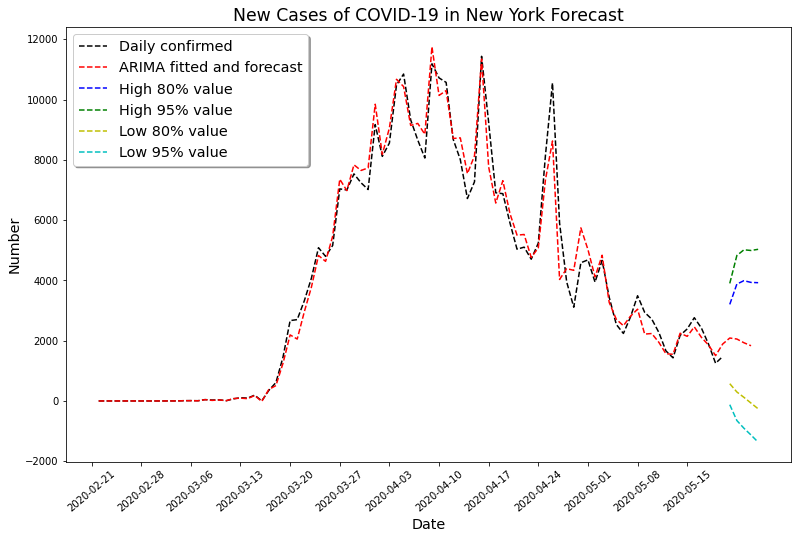

In [24]:
id_predict = list(range(90,95))
id_all = list(range(1,94))

data_fitted_predict = autoarima.fitted_.collect()['FITTED'].append(result.collect()['FORECAST'])
data_fitted = ny_confd_delta.collect()['New York']

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Forecast', fontsize='xx-large')
ax.plot(ny_confd_delta.collect()['ID'], data_fitted, 'k--', label='Daily confirmed')
ax.plot(id_all, data_fitted_predict[1:94], 'r--', label='ARIMA fitted and forecast')
ax.plot(id_predict,  result.collect()['HI80'], 'b--', label='High 80% value')
ax.plot(id_predict,  result.collect()['HI95'], 'g--', label='High 95% value')
ax.plot(id_predict,  result.collect()['LO80'], 'y--', label='Low 80% value')
ax.plot(id_predict,  result.collect()['LO95'], 'c--', label='Low 95% value')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us_delta.collect()['Timestamp']
#Date.append(pd.DataFrame(['5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20']))
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### Additive Model Forecast

In [25]:
ny_confd_delta = confd_us_delta.select('Timestamp','New York').cast('New York', 'INT')
ny_confd_delta = ny_confd_delta.cast('Timestamp', 'DATE')
print(ny_confd_delta.head(3).collect())
print(ny_confd_delta.dtypes())

    Timestamp  New York
0  2020-02-21         0
1  2020-02-22         0
2  2020-02-23         0
[('Timestamp', 'DATE', 10, 10, 10, 0), ('New York', 'INT', 10, 10, 10, 0)]


Predicted data:

In [26]:
from hana_ml.dataframe import create_dataframe_from_pandas
data = {
    'Timestamp':['2020-5-20', '2020-5-21', '2020-5-22', '2020-5-23', '2020-5-24'],
    'New York':[0, 0, 0, 0, 0]
}
predict = pd.DataFrame(data)
predict_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df= predict, table_name='ADDITIVE_PREDICT_TBL', force=True, replace=True)
predict_df = predict_df.cast('New York', 'DOUBLE')
predict_df = predict_df.cast('Timestamp', 'DATE')
print(predict_df.collect())
print(predict_df.dtypes())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


    Timestamp  New York
0  2020-05-20       0.0
1  2020-05-21       0.0
2  2020-05-22       0.0
3  2020-05-23       0.0
4  2020-05-24       0.0
[('Timestamp', 'DATE', 10, 10, 10, 0), ('New York', 'DOUBLE', 15, 15, 15, 0)]


In [27]:
from hana_ml.algorithms.pal.tsa import additive_model_forecast

amf = additive_model_forecast.AdditiveModelForecast()
amf.fit(ny_confd_delta)

print(amf.model_.collect())

   ROW_INDEX                                      MODEL_CONTENT
0          0  {"FLOOR":0.0,"GROWTH":"linear","SEASONALITY_MO...


In [28]:
result = amf.predict(predict_df)
print(result.collect())

    Timestamp         YHAT   YHAT_LOWER    YHAT_UPPER
0  2020-05-20  6023.608932  1906.062547  10195.760392
1  2020-05-21  6229.385815  2007.694276  10405.420492
2  2020-05-22  6116.905847  1992.743665  10134.645040
3  2020-05-23  6297.310586  2494.906012  10722.820229
4  2020-05-24  5552.090529  1461.648161  10091.915201


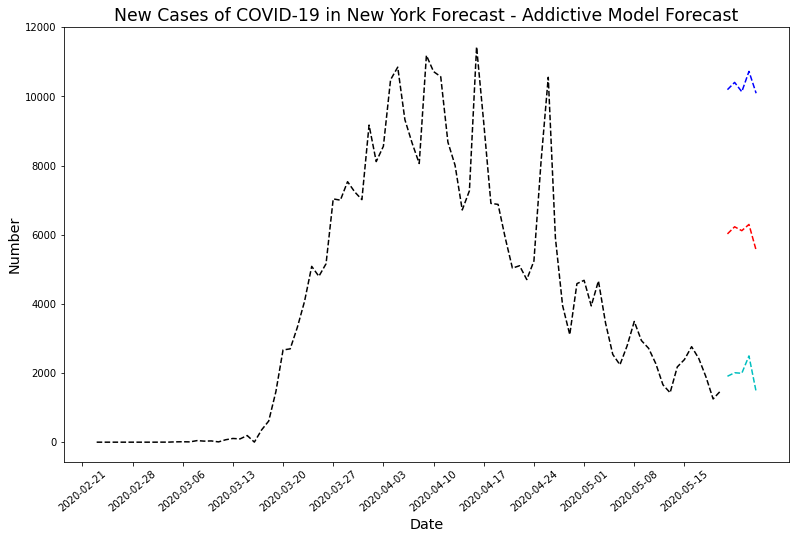

In [29]:
id_predict = list(range(90,95))
id_all = list(range(1,95))

data_all = ny_confd_delta.collect()['New York'].append(result.collect()['YHAT']) 
upper = result.collect()['YHAT_UPPER']
lower = result.collect()['YHAT_LOWER']

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Forecast - Addictive Model Forecast', fontsize='xx-large')
ax.plot(id_all[1:89], data_all[1:89], 'k--', label='confirmed')
ax.plot(id_all[89:94], data_all[89:94], 'r--', label='predict data')
ax.plot(id_predict,  upper, 'b--', label='upper bound')
ax.plot(id_predict,  lower, 'c--', label='lower bound')
Date = confd_us_delta.collect()['Timestamp']
#Date.append(pd.DataFrame(['5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20']))
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

### Regression - SVR

In [30]:
ny_confd_delta = confd_us_delta.select('New York').cast('New York', 'INT')
print(ny_confd_delta.head(3).collect())
print(ny_confd_delta.dtypes())

   New York
0         0
1         0
2         0
[('New York', 'INT', 10, 10, 10, 0)]


In [31]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
values = pd.DataFrame(ny_confd_delta.collect()['New York'])
regression_data = series_to_supervised(values, 5)
print(regression_data.head(5))

   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
5        0.0        0.0        0.0        0.0        0.0        0
6        0.0        0.0        0.0        0.0        0.0        0
7        0.0        0.0        0.0        0.0        0.0        0
8        0.0        0.0        0.0        0.0        0.0        0
9        0.0        0.0        0.0        0.0        0.0        0


In [32]:
svr_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=regression_data, table_name='NY_SVR_DATA_TBL', force=True, replace=True)
svr_df =svr_df.add_id('ID')
print(svr_df.head(3).collect())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   1        0.0        0.0        0.0        0.0        0.0        0
1   2        0.0        0.0        0.0        0.0        0.0        0
2   3        0.0        0.0        0.0        0.0        0.0        0


### Model Training
Split the dataset into train_data and test_data:

In [33]:
from hana_ml.algorithms.pal.partition import train_test_val_split
train_data, test_data, validate_data = train_test_val_split(svr_df, training_percentage=0.8, testing_percentage=0.2, validation_percentage=0)
print(train_data.count())
print(train_data.collect().head(3))
print(test_data.count())
print(test_data.collect().head(3))

67
   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   1        0.0        0.0        0.0        0.0        0.0        0
1   2        0.0        0.0        0.0        0.0        0.0        0
2   3        0.0        0.0        0.0        0.0        0.0        0
17
   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   4        0.0        0.0        0.0        0.0        0.0        0
1  15        8.0       45.0       30.0       36.0        8.0       70
2  17       30.0       36.0        8.0       70.0      107.0       94


In [34]:
from hana_ml.algorithms.pal.svm import SVR
featurs_svr = ['var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']
svr = SVR(kernel = 'rbf',
          scale_info='standardization', 
          gamma = 0.3,
          random_state=10,
          scale_label=True)
svr.fit(train_data, key='ID', features = featurs_svr, label = 'var1(t)')

print(svr.model_.collect())
print(svr.stat_.collect())

   ROW_INDEX                                      MODEL_CONTENT
0          0  {"C":100.0,"CONTENT":"{\"impute_model\":{\"col...
1          1  7068417702779,1.2789007060242485,1.30516571961...
2          2  },{"index":99,"prob":0.0043859649122807015},{"...
  STAT_NAME          STAT_VALUE
0       obj  -70.97037100002143
1      iter                1171


### Model Score
Calculate the r2_score:

In [35]:
print(svr.score(test_data, key='ID', features = featurs_svr, label = 'var1(t)'))

0.5760917205929874


### Cross Validation

In [36]:
svr_cv = SVR(kernel='rbf', 
             scale_info='standardization', 
             scale_label=True, 
             resampling_method='cv',
             fold_num=10, 
             repeat_times=5,
             random_state=11,
             search_strategy='grid',
             param_range = [('gamma', [0.1, 0.1, 1.0])])
svr_cv.fit(train_data, key='ID', label = 'var1(t)')

print(svr_cv.model_.collect())
print(svr_cv.stat_.collect())

IndexError: list index out of range

In [ ]:
train_data.collect()

In [ ]:
print(svr_cv.score(test_data, key='ID', features = featurs_svr, label = 'var1(t)'))

## Close HANA Connection

In [ ]:
connection_context.close()